In [1]:
import numpy as np
import os
from time import time
import pandas as pd
import string
import re
import multiprocessing
from nltk.corpus import stopwords
import nltk 
from gensim.models import Word2Vec
#from nltk.stem import WordNetLemmatizer
from gensim.models.word2vec import Text8Corpus
from sklearn.cluster import KMeans
from sknetwork.ranking import PageRank
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinriv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def fileRead(file=None):
    """
Function just reads file joins the entire content as single line and returns  
"""
    # Open a file: file
    f =open(file,mode='r',encoding="utf-8")
 
    # read all lines at once
    all_contents = f.read()
    # close the file
    f.close()
    return all_contents



def tokenize(text):
    """
Alternate way to tokenize instead of nltk one. 
"""
    pattern = re.compile(r'[A-Za-z]+[\']?[A-Za-z]?')
    return pattern.findall(text.lower())  



def readCSV(file):
    """
    This function cleans text removes : 
    1> removes numbers 
    2> removes puncuations 
    3> performs word tokenization
    4> lowers the case
"""
    df = pd.read_csv(file,header=None,usecols=[0])
    df.columns=["sent"]
    tr_table = str.maketrans('', '', string.punctuation)
    df["sent"] = df['sent'].apply(lambda x: nltk.tokenize.word_tokenize(x.lower().translate(tr_table)))
    return df["sent"]



                
def clean_my_priv_policies(input_text_dir="corpus/other_corpus/",out_put_path="corpus/corpus/pretty_print_uniquified"):
    """
    These are policies that I accumulated manually for using in building wokrd2vec model 
"""                
 
    ## Reading sentence from files. 
    oth_path = input_text_dir
    out_file= out_put_path+"/mycorpus.csv"

    out = open(out_file,mode="w+",encoding="utf-8")

    for fname in os.listdir(oth_path):
        f=os.path.join(oth_path,fname)
        #print("processing :: ",fname)

        cnts = fileRead(file=f)
        cnts=re.sub("\,|e\.g|i\.e|U\.S|[0-9]|\s\s+|\(|\)","",cnts)  
        ll = cnts.split(".")
        tr_table = str.maketrans('', '', string.punctuation)
        for sent in ll:
            sent=sent.strip()
            sent =sent.lower().translate(tr_table)
            # print(sent)
            if len(sent) > 10:
                out.write(sent + "\n")

    out.close()        

    



# Generator to feed into word to vector. 
class TrainSentences(object):
    def __init__(self, dirname,remove_stop_words):
        self.dirname = dirname
        self.remove_stop_words=remove_stop_words
        self.stop_words=stopwords.words('english')
        #self.lemmatizer = WordNetLemmatizer()
         
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            # print("processing :: ",fname)
            ful_f = os.path.join(self.dirname, fname)
            if fname == "text8":
                corpus = Text8Corpus(ful_f)
                for doc in corpus:
                    word_tokens=[word for word in doc if not word in self.stop_words]
                    yield word_tokens
                        
            else:
                x = readCSV(ful_f)
                for word_tokens in x:
                    word_tokens=[word for word in word_tokens if not word in self.stop_words]
                    yield word_tokens
                
                

In [16]:
t = time()
clean_my_priv_policies()
pth="corpus/corpus/pretty_print_uniquified"
sents = TrainSentences(pth,False)
model = Word2Vec(sents,window=5 ,min_count=3,vector_size=200,sg=1,workers=10,alpha=0.05 )
print(model)
print('Time to build model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:50:58: collecting all words and their counts
INFO - 19:50:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:51:01: PROGRESS: at sentence #10000, processed 134059 words, keeping 2277 word types
INFO - 19:51:31: collected 253862 word types from a corpus of 11117386 raw words and 18666 sentences
INFO - 19:51:31: Creating a fresh vocabulary
INFO - 19:51:31: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 99957 unique words (39.37% of original 253862, drops 153905)', 'datetime': '2023-04-30T19:51:31.812569', 'gensim': '4.2.0', 'python': '3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 19:51:31: Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 10928157 word corpus (98.30% of original 11117386, drops 189229)', 'datetime': '2023-04-30T19:51:31.813553', 'gensim': '4.2.0', 'python': '3.6.8 (tags/v3.6.8:3c6b436a57, Dec 

INFO - 19:52:34: EPOCH 1 - PROGRESS: at 79.83% examples, 191316 words/s, in_qsize 1, out_qsize 0
INFO - 19:52:35: EPOCH 1 - PROGRESS: at 80.05% examples, 193547 words/s, in_qsize 1, out_qsize 0
INFO - 19:52:36: EPOCH 1 - PROGRESS: at 80.29% examples, 196261 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:37: EPOCH 1 - PROGRESS: at 80.51% examples, 198006 words/s, in_qsize 1, out_qsize 1
INFO - 19:52:38: EPOCH 1 - PROGRESS: at 80.74% examples, 199856 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:39: EPOCH 1 - PROGRESS: at 80.93% examples, 199990 words/s, in_qsize 0, out_qsize 1
INFO - 19:52:40: EPOCH 1 - PROGRESS: at 81.13% examples, 199570 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:41: EPOCH 1 - PROGRESS: at 81.38% examples, 202180 words/s, in_qsize 0, out_qsize 2
INFO - 19:52:42: EPOCH 1 - PROGRESS: at 81.61% examples, 203400 words/s, in_qsize 1, out_qsize 0
INFO - 19:52:43: EPOCH 1 - PROGRESS: at 81.84% examples, 204703 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:44: EPOCH 1 - PRO

INFO - 19:54:01: EPOCH 3 - PROGRESS: at 78.66% examples, 165458 words/s, in_qsize 0, out_qsize 1
INFO - 19:54:02: EPOCH 3 - PROGRESS: at 78.88% examples, 170733 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:03: EPOCH 3 - PROGRESS: at 79.12% examples, 176403 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:04: EPOCH 3 - PROGRESS: at 79.30% examples, 176899 words/s, in_qsize 0, out_qsize 1
INFO - 19:54:05: EPOCH 3 - PROGRESS: at 79.53% examples, 181512 words/s, in_qsize 0, out_qsize 1
INFO - 19:54:06: EPOCH 3 - PROGRESS: at 79.77% examples, 185716 words/s, in_qsize 0, out_qsize 2
INFO - 19:54:07: EPOCH 3 - PROGRESS: at 80.00% examples, 188640 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:08: EPOCH 3 - PROGRESS: at 80.22% examples, 191241 words/s, in_qsize 1, out_qsize 0
INFO - 19:54:09: EPOCH 3 - PROGRESS: at 80.43% examples, 192902 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:10: EPOCH 3 - PROGRESS: at 80.64% examples, 194034 words/s, in_qsize 1, out_qsize 0
INFO - 19:54:11: EPOCH 3 - PRO

INFO - 19:55:24: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=99957, vector_size=200, alpha=0.05>', 'datetime': '2023-04-30T19:55:24.068056', 'gensim': '4.2.0', 'python': '3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


Word2Vec<vocab=99957, vector_size=200, alpha=0.05>
Time to build model: 4.43 mins


In [17]:
# loaded_model = Word2Vec.load('model.txt')
# print(loaded_model)
result = model.wv.similar_by_word("company")
print("Similar words for company")
print(result)
result = model.wv.similar_by_word("privacy")
print("Similar words for privacy")
print(result)
result = model.wv.similar_by_word("data")
print("Similar words for data")
print(result) 

result = model.wv.similar_by_word("cookies")
print("Similar words for cookies")
print(result)
model.wv.save("vectors.kv")

INFO - 19:56:23: KeyedVectors lifecycle event {'fname_or_handle': 'vectors.kv', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-30T19:56:23.297876', 'gensim': '4.2.0', 'python': '3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
INFO - 19:56:23: storing np array 'vectors' to vectors.kv.vectors.npy


Similar words for company
[('companies', 0.6636916399002075), ('subsidiaries', 0.6458300948143005), ('ingka', 0.637399435043335), ('corporation', 0.6256875395774841), ('unocal', 0.623038113117218), ('ipo', 0.6227559447288513), ('bottlers', 0.6196237206459045), ('subsidiary', 0.6192387342453003), ('nasd', 0.6158478856086731), ('globalsoft', 0.612205445766449)]
Similar words for privacy
[('thirdparty', 0.5526708364486694), ('wep', 0.5470161437988281), ('crms', 0.5359306335449219), ('cbpr', 0.5289835929870605), ('vcdpa', 0.5225772261619568), ('configure', 0.5206857919692993), ('optout', 0.5197436809539795), ('deidentified', 0.513933002948761), ('settings', 0.5118246674537659), ('companyorganization', 0.5018110871315002)]
Similar words for data
[('information', 0.7200251221656799), ('gedcom', 0.660322368144989), ('escrow', 0.6600826382637024), ('deidentified', 0.6575762629508972), ('froogle', 0.6521234512329102), ('aggregated', 0.651265025138855), ('ssks', 0.6418318152427673), ('decompress

INFO - 19:56:23: saved vectors.kv


### Plotting words showing similarities


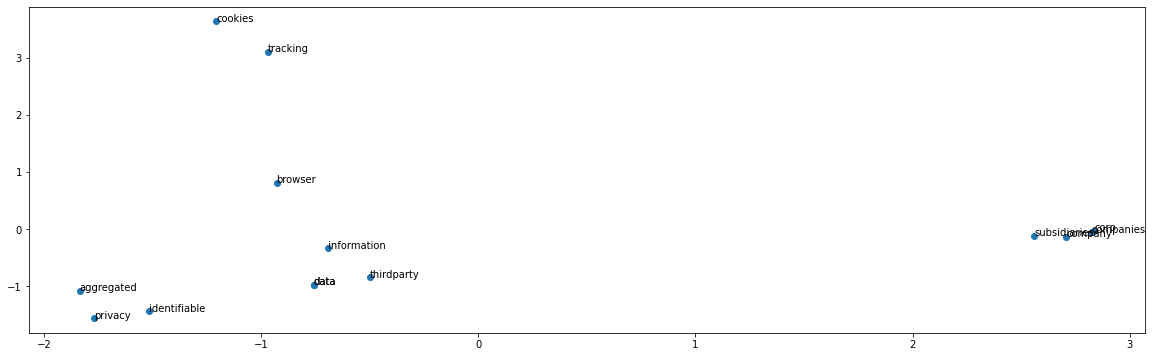

In [20]:
# Picking out words from vocabulary and plotting them. 
wordlist=["company","privacy","data", "subsidiaries","corp","companies",
         "browser","thirdparty","information","data","aggregated","identifiable",
          "tracking","cookies"]

X=[]
for word in wordlist:
    if word in model.wv.key_to_index:
        X.append(model.wv.get_vector(word))


#print(X)

pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(20,6))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(wordlist):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.show()    

In [21]:
    
def get_sentences_vectors_from_txt(input_text_dir="test_policies/",text_file=None,model=model):                
    ## Reading sentence from files. 
    f= input_text_dir+text_file
    cnts = fileRead(file=f)
    ll = cnts.split(".")
    tr_table = str.maketrans('', '', string.punctuation)
    stop_words=stopwords.words('english')
    res=[]
    resIdx=dict()
    for idx,sent in enumerate(ll):
        #print(idx)
        origSent=sent
        sent=sent.strip()
        origSent=sent
        sent=re.sub("\,|e\.g|i\.e|U\.S|[0-9]|\s\s+|\(|\)","",sent)
        sent =nltk.tokenize.word_tokenize(sent.lower().translate(tr_table))
        word_tokens=[word for word in sent if not word in stop_words]
        #print(word_tokens)
        if len(word_tokens) > 4:
            resIdx[idx]=origSent
            sent_vect=get_sentence_vector(sentence=sent,model=model)
            res.append(sent_vect)
            
    # reset indexes 
    fresIdx=dict()
    cnt=0
    for k in resIdx.keys():
        fresIdx[cnt]=resIdx[k]
        cnt=cnt+1
        
    return np.array(res),fresIdx


def get_sentence_vector(sentence=[],model=model):
    lv=[]
    for word in sentence:
        if word in model.wv.key_to_index:
            lv.append(model.wv.get_vector(word))
            
    # average all vectors from words          
    arr =  np.average(np.array(lv),axis=0)
    # normalize final vector 
    arr = scale(arr)
    return arr



def sort_dict(d={},how_many=2):
    rdict = sorted(d.items(), key=lambda x:x[1])    
    rdict=dict(rdict)
    res=[]
    cnt=0
    for k in rdict.keys():
        if cnt < how_many:
            res.append(k)
            cnt=cnt+1
        
    return res    
        


def scale(arr):
    return arr/np.sqrt((arr**2).sum())
        

# def find_nearest_sentences_in_cluster(kmeans=kmeans,sentences_per_cluster=1):
#     f_indexes=[]
#     for i,vect in enumerate(kmeans.cluster_centers_):
#         inputV=[idx for idx , v in enumerate(kmeans.labels_) if v == i]
#        # print(inputV)
#         topSDict = dict()
#         for ii in inputV:
#            # print(resIdx.get(ii))
#             dist = np.linalg.norm(vect - res[ii])
#             topSDict[ii]=dist
#         t = sort_dict(d=topSDict,how_many=sentences_per_cluster)
#         for iii in t:
#             f_indexes.append(iii)
         
#     return  f_indexes   

    
    

def find_nearest_sentences_in_cluster(kmeans=None,sentences_per_cluster=1):
    f_indexes=[]
    for i,vect in enumerate(kmeans.cluster_centers_):
        inputV=[idx for idx , v in enumerate(kmeans.labels_) if v == i]
       # print(inputV)
        topSDict = dict()
        for ii in inputV:
           # print(resIdx.get(ii))
            dist = np.linalg.norm(vect - res[ii])
            topSDict[ii]=dist
        t = sort_dict(d=topSDict,how_many=sentences_per_cluster)
        for iii in t:
            f_indexes.append(iii)
         
    return  f_indexes   




def create_cosine_similiarity_matrix(arr):
    """
In our case we are normalizing vectors such that is magnitued is 1. 
""" 
    l = len(arr)
    vl = len(arr[0,:])
    sim_mat=np.zeros((l,l))
    for i, v1 in enumerate(arr):
        for j, v2 in enumerate(arr):
            if i != j:
                #print(i,j)
                v11= v1.reshape(1,vl)
                v22= v2.reshape(1,vl)
                #print(np.dot(v11,v22.T))
                sim_mat[i][j]=np.dot(v11,v22.T)
                
        
    return sim_mat
 
    
    
def print_helper(resDict={},idxList=[]):
    for k in idxList:
        print("==" + resDict[k] + "." + "==")

    print("*"*50)
    
    

## Common steps in the flow : 
1> Generate Sentecne vector by collecting word vectors.  
2> Each sentence goes through : text cleaning process 
3> Sentence tokenize.   
4> Keep only words which are in our word2vec model.    
5> Average all vectors to get sentence vector. 

## K-Means clustering 
 
1> Run K means clusters.  
2> Perform selection of of sentences from original text.  
3> User can provide how many sentence want to be picked. We find the closest sentence to each centroid from each cluster and return.    
 
## Graph Based Ranking of sentences
1> Create cosine matrix for each sentence vector with each other:  matrix would be of size (n_sentence,n_sentence)
2> We have already normalized the vector so its magnitude is 1  
3> Use pageranking algorithm to rank sentences given the weights in adjacency matrxi by cosine similarities.  


In [22]:

test_file="facebook.txt" 
res, resIdx = get_sentences_vectors_from_txt(text_file=test_file,model=model)


print(f"=================K MEAN START for {test_file}=================================")
#print(res.shape) 
kmeans = KMeans(n_clusters=8, random_state=0).fit(res)
#print(kmeans.labels_)
#print(len(kmeans.labels_))
print("*"*50)  
final_indexes=find_nearest_sentences_in_cluster(kmeans=kmeans,sentences_per_cluster=1)
print_helper(resIdx,final_indexes)

print(f"=================PageRanking for {test_file}=================================")
print(res.shape)
 

cos_matrix = create_cosine_similiarity_matrix(res)
#print(cos_matrix.shape) 
pagerank = PageRank()
pagerank.damping_factor=0.85
pagerank.fit(cos_matrix)
#print(pagerank.scores_) 
#print(len(pagerank.scores_) )

# create dictionary of values
scores_dict = dict()
for i,v in enumerate(pagerank.scores_):
    scores_dict[i]=v
  
final_indexes=sort_dict(scores_dict,how_many=8)
print_helper(resIdx,final_indexes)



=================K MEAN START for facebook.txt=================================
**************************************************
==If you make a payment on Facebook, you agree to our Payments Terms unless it is stated that other terms apply.==
==The following provisions apply to users and non-users who interact with Facebook outside the United States: You consent to having your personal data transferred to and processed in the United States.==
==If we remove your content for infringing someone else's copyright, and you believe we removed it by mistake, we will provide you with an opportunity to appeal.==
==In addition, your advertising or other commercial or sponsored activity or content placed on Facebook or our publisher network will comply with our Advertising Policies.==
==You may also delete your account or disable your application at any time.==
==If you repeatedly infringe other people's intellectual property rights, we will disable your account when appropriate.==
==You provi